In [30]:
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset
from Light.dataset import Sampler_Loaders, SubScriptDatasets

import os
from hyperpyyaml import load_hyperpyyaml
from Light.model import SpeakerLoss
from geomloss import SamplesLoss

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [26]:
def k_center_greedy(matrix, budget: int, metric, device, random_seed=None, index=None, already_selected=None,
                    print_freq: int = 20):
    if type(matrix) == torch.Tensor:
        assert matrix.dim() == 2
    elif type(matrix) == np.ndarray:
        assert matrix.ndim == 2
        matrix = torch.from_numpy(matrix).requires_grad_(False).to(device)

    sample_num = matrix.shape[0]
    assert sample_num >= 1

    if budget < 0:
        raise ValueError("Illegal budget size.")
    elif budget > sample_num:
        budget = sample_num

    if index is not None:
        assert matrix.shape[0] == len(index)
    else:
        index = np.arange(sample_num)

    assert callable(metric)

    already_selected = np.array(already_selected)

    with torch.no_grad():
        np.random.seed(random_seed)
        if already_selected.__len__() == 0:
            select_result = np.zeros(sample_num, dtype=bool)
            # Randomly select one initial point.
            already_selected = [np.random.randint(0, sample_num)]
            budget -= 1
            select_result[already_selected] = True
        else:
            select_result = np.in1d(index, already_selected)

        num_of_already_selected = np.sum(select_result)

        # Initialize a (num_of_already_selected+budget-1)*sample_num matrix storing distances of pool points from
        # each clustering center.
        dis_matrix = -1 * torch.ones([num_of_already_selected + budget - 1, sample_num], requires_grad=False).to(device)

        dis_matrix[:num_of_already_selected, ~select_result] = metric(matrix[select_result], matrix[~select_result])

        mins = torch.min(dis_matrix[:num_of_already_selected, :], dim=0).values

        for i in range(budget):
            # if i % print_freq == 0:
            #     print("| Selecting [%3d/%3d]" % (i + 1, budget))
            p = torch.argmax(mins).item()
            select_result[p] = True

            if i == budget - 1:
                break
            mins[p] = -1
            dis_matrix[num_of_already_selected + i, ~select_result] = metric(matrix[[p]], matrix[~select_result])
            mins = torch.min(mins, dis_matrix[num_of_already_selected + i])
    
    return index[select_result]

In [3]:
embeddings = torch.load('data/vox2/embeddings.pth')['embeddings']

In [5]:
data_root = '/home/yangwenhao/project/SpeakerVerification-pytorch'
train_config = 'data/vox2/model.2024.01.29.yaml'

In [6]:
with open(train_config, 'r') as f:
    config_args = load_hyperpyyaml(f)

In [7]:
train_dir, valid_dir, train_extract_dir = SubScriptDatasets(config_args)

In [9]:
batch_size = config_args['batch_size'] 
num_classes = config_args['num_classes']
# model.eval()

batch_loader = torch.utils.data.DataLoader(
    train_dir, batch_size=batch_size, num_workers=config_args['nj'])
sample_num = len(train_dir)

In [11]:
# pbar = tqdm(enumerate(batch_loader), ncols=50)
labels = []

for uid, s, e in train_dir.base_utts:
    sid = train_dir.utt2spk_dict[uid]
    label = train_dir.spk_to_idx[sid]

    labels.append(label)

0it [00:00, ?it/s]

In [12]:
labels = torch.LongTensor(labels)

In [15]:
this_idxs = np.arange(10)
this_labs, this_embs = [], []

for i in this_idxs:
    this_idx = labels == i
    this_labs.append(labels[this_idx])
    this_embs.append(embeddings[this_idx])

In [16]:
this_labs = torch.cat(this_labs, dim=0)
this_embs = torch.cat(this_embs, dim=0)

In [20]:
def euclidean_dist(x, y):
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()
    return dist

def cost_func(a, b, p=2, metric='cosine'):
    """ a, b in shape: (B, N, D) or (N, D)
    """ 
    assert type(a)==torch.Tensor and type(b)==torch.Tensor, 'inputs should be torch.Tensor'
    if metric=='euclidean' and p==1:
        return geomloss.utils.distances(a, b)
    elif metric=='euclidean' and p==2:
        return geomloss.utils.squared_distances(a, b)
    else:
        if a.dim() == 3:
            x_norm = a / (a.norm(dim=2)[:, :, None]+1e-12)
            y_norm = b / (b.norm(dim=2)[:, :, None]+1e-12)
            M = 1 - torch.bmm(x_norm, y_norm.transpose(-1, -2))
        elif a.dim() == 2:
            x_norm = a / (a.norm(dim=1)[:, None]+1e-12)
            y_norm = b / (b.norm(dim=1)[:, None]+1e-12)
            M = 1 - torch.mm(x_norm, y_norm.transpose(0, 1))
        # M = pow(M, p)
        return M

In [29]:
indexs.shape

(2417,)

In [31]:
all_vectors = PCA(n_components=32).fit_transform(this_embs.numpy())
c_embedded  = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(all_vectors)

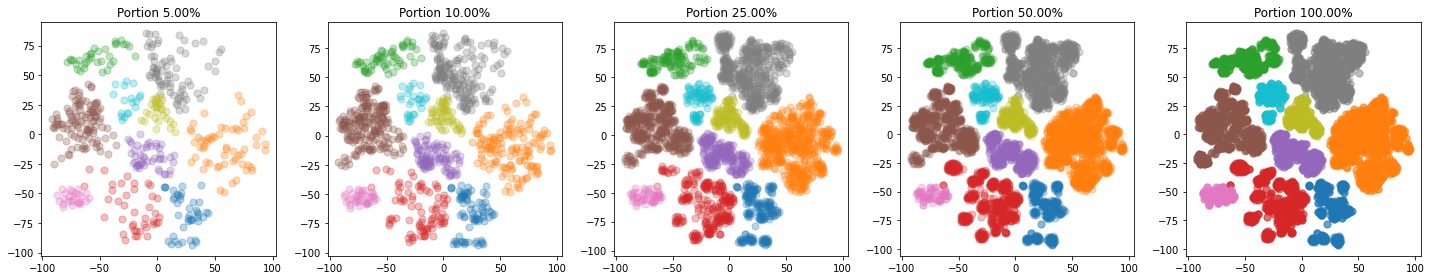

In [53]:
# x2 = torch.tensor(prototype_center[labs[x2_select_ids]]).type(dtype)
fig = plt.figure(figsize=(20, 4))
 
plot_idx = np.arange(10)
ratios   = [0.05, 0.1, 0.25, 0.5]
num_pert = 1 + len(ratios)

for i, r in enumerate(ratios):
    budget = int(this_labs.shape[0] * r)
    indexs = k_center_greedy(matrix=this_embs, budget=budget, metric=cost_func, device='cpu', random_seed=1234,
                    index=None, already_selected=[])

    plt.subplot(1,num_pert,1+i)
    plt.title('Portion {:.2f}%'.format(r*100))
    for idx in plot_idx:
        this_idx = this_labs[indexs] == idx
        plt.scatter(c_embedded[:, 0][indexs][this_idx], c_embedded[:, 1][indexs][this_idx],
                    marker='o', s=50, alpha=0.3)
        
plt.subplot(1,num_pert,num_pert)
plt.title('Portion {:.2f}%'.format(1*100))
for i in plot_idx:
    # this_idx = np.concatenate([s_labs, s_labs], axis=0) == i
    idx = this_labs == i
    plt.scatter(c_embedded[:, 0][idx], c_embedded[:, 1][idx],
                marker='o', s=50, alpha=0.3)

plt.tight_layout()
# plt.savefig('geomloss_sgd_more_random_otherbatchs.png')

In [35]:
this_idx.shape

(2417,)

In [80]:
a = torch.tensor([2.], requires_grad=True)

y = a * torch.tensor([2.]) ** 2

In [59]:
loss = nn.MSELoss()

In [81]:
l = loss(y, torch.tensor([16.]))

In [62]:
torch.autograd.backward(l, a)

In [63]:
a_grad

tensor([-64.])

In [82]:
torch.autograd.backward(l, retain_graph=True)
a.grad.requires_grad = True


In [83]:
torch.autograd.backward(a.grad, retain_graph=True)

In [84]:
a.grad.grad

tensor([1.])